# IMPORTS

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# Classifier Libraries
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# DATA LOAD

In [ ]:
heart_disease = fetch_openml(name='heart-statlog', version=1)


x = heart_disease.data
y = heart_disease.target



display(x.head())
display(y.head())


,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3


,class
0,present
1,absent
2,present
3,absent
4,absent


In [ ]:
# Cost Matrix extracted via https://archive.ics.uci.edu/dataset/145/statlog+heart
cost_matrix = np.array([[0, 1],  # Cost of predicting class 0 - Absence (no heart disease)
                        [5, 0]])  # Cost of predicting class 1 = Presence (heart disease)


# DATA VISUALISATION

In [ ]:
df = pd.concat([x, y], axis=1)
df.columns = heart_disease.feature_names + ['target']

#  Map the target labels ('absent' and 'present') to binary (0 and 1)
df['target'] = df['target'].map({'absent': 0, 'present': 1})

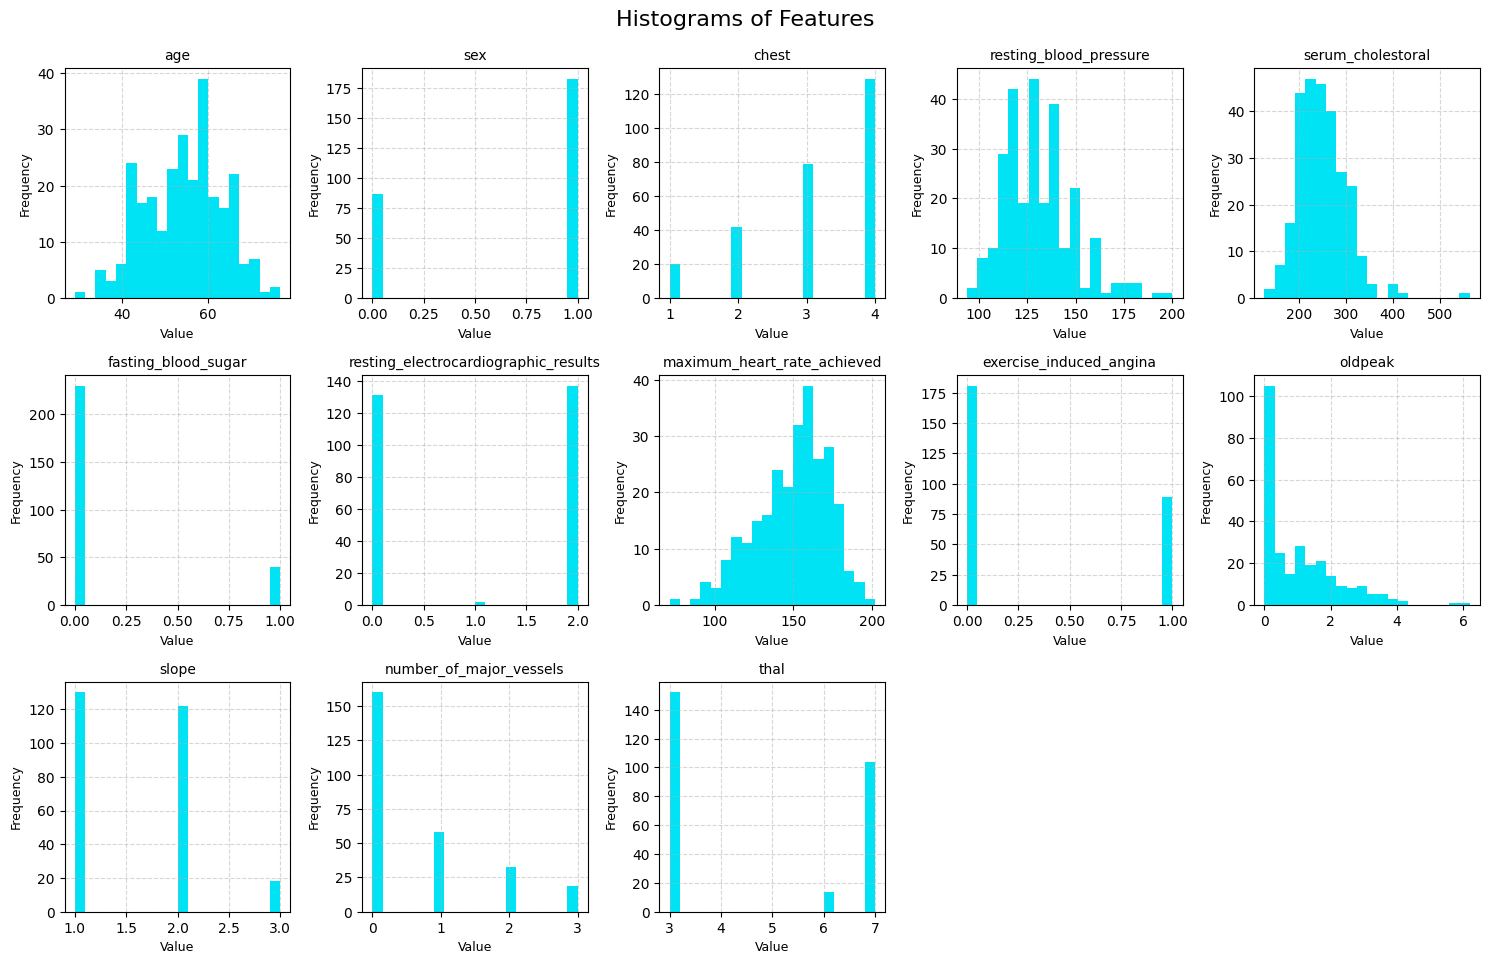

In [ ]:
features = df.drop(columns=['target']).columns

plt.figure(figsize=(15, 12))


for i, feature in enumerate(features, 1):
    plt.subplot(4, 5, i)
    plt.hist(df[feature], bins=20, color='#00e3f5')
    plt.title(f'{feature}', fontsize=10)
    plt.xlabel('Value', fontsize=9)
    plt.ylabel('Frequency', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.5)


plt.tight_layout()
plt.suptitle('Histograms of Features', y=1.02, fontsize=16)
plt.show()

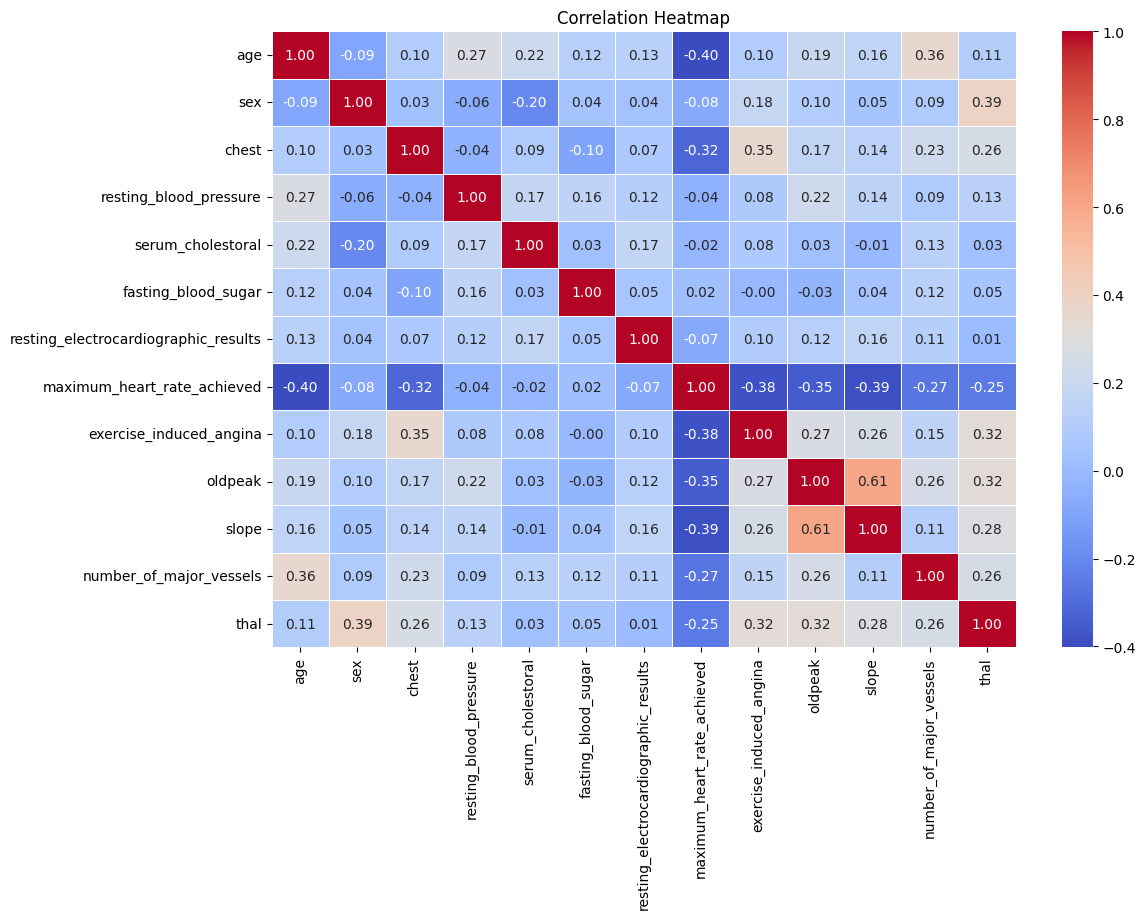

In [ ]:
correlation_matrix = df[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-16-6724ca961c6d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df, palette='coolwarm')


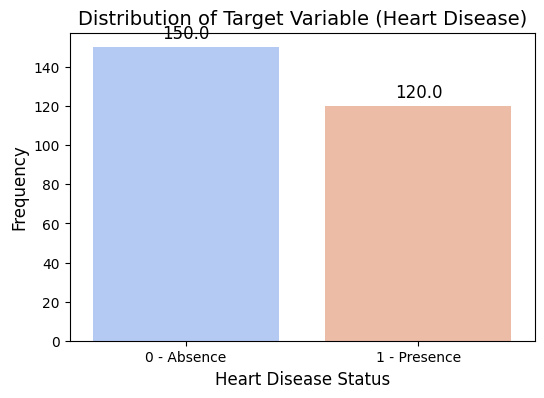


Absolute difference between the two classes: 30


In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=df, palette='coolwarm')


plt.title('Distribution of Target Variable (Heart Disease)', fontsize=14)
plt.xlabel('Heart Disease Status', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 - Absence', '1 - Presence'], rotation=0)


counts = df['target'].value_counts()

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')


plt.show()

absence_count = counts.get(0, 0)
presence_count = counts.get(1, 0)
absolute_difference = abs(absence_count - presence_count)

print(f'\nAbsolute difference between the two classes: {absolute_difference}')


# Data Preprocessing

In [ ]:
df.head(5)

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,target
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [ ]:
df.describe()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


In [ ]:
# Check for empty values
df.isnull().sum()

,0
age,0
sex,0
chest,0
resting_blood_pressure,0
serum_cholestoral,0
fasting_blood_sugar,0
resting_electrocardiographic_results,0
maximum_heart_rate_achieved,0
exercise_induced_angina,0
oldpeak,0


In [ ]:
# Define Scaler
numerical_features = ['age', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved', 'oldpeak']

scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

In [ ]:
# Split and Scale data
inputs = df.drop(columns='target')
targets = df['target']

x_train, x_test, y_train, y_test = train_test_split(inputs, targets, train_size=0.7, random_state=42)
print('Training set - shape:', x_train.shape, y_train.shape)
print('Test set - shape:', x_test.shape, y_test.shape)

scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Training set - shape: (189, 13) (189,)
Test set - shape: (81, 13) (81,)


In [ ]:
print('Scaled sample:', x_train_scaled[0])
print('\nUnscaled sample:', np.array(x_train)[0])

Scaled sample: [ 0.2468849  -1.21809085 -0.96400751 -1.0219408   0.28883261  1.
  4.          0.          0.          1.          2.          0.
  6.        ]

Unscaled sample: [ 57.    1.    4.  110.  201.    0.    0.  126.    1.    1.5   2.    0.
   6. ]


# First Part: Cost-Sensitive Learning

---



In the first part of the project, we will explore cost-sensitice learning techniques to train models that prioritize classes with high misclassification costs.

## Rebalancing

In [ ]:
from imblearn.over_sampling import RandomOverSampler
class_names = ['absent', 'present']
# Counter: {0: 101, 1: 88}
# Cost:
# [(0, 1) cost of missclassifying '0'
#  (5, 0)] cost of missclassifying '1'


print('|================= Without sampling =================|\n')
print('- Random Forest:\n')
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred), '\n')

print('- Linear SVM:\n')
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred), '\n')

print('- Naive Bayes:\n')
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred), '\n')

#                              -----

print('|================= With Over-sampling =================|\n')
sampler = RandomOverSampler(sampling_strategy={0: 101*1, 1: 88*5}, random_state=42)
x_rs, y_rs = sampler.fit_resample(x_train, y_train)

print('- Random Forest:\n')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_rs, y_rs)
y_pred = rf_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred), '\n')

print('- Linear SVM:\n')
svm_model = SVC(kernel='linear')
svm_model.fit(x_rs, y_rs)
y_pred = svm_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred), '\n')

print('- Naive Bayes:\n')
nb_model = GaussianNB()
nb_model.fit(x_rs, y_rs)
y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred), '\n')

|================= Without sampling =================|

- Random Forest:

              precision    recall  f1-score   support

      absent       0.77      0.88      0.82        49
     present       0.76      0.59      0.67        32

    accuracy                           0.77        81
   macro avg       0.76      0.74      0.74        81
weighted avg       0.76      0.77      0.76        81

[[43  6]
 [13 19]] 

- Linear SVM:

              precision    recall  f1-score   support

      absent       0.82      0.92      0.87        49
     present       0.85      0.69      0.76        32

    accuracy                           0.83        81
   macro avg       0.83      0.80      0.81        81
weighted avg       0.83      0.83      0.82        81

[[45  4]
 [10 22]] 

- Naive Bayes:

              precision    recall  f1-score   support

      absent       0.82      0.94      0.88        49
     present       0.88      0.69      0.77        32

    accuracy                       

We can see the over-sampling worsen the results of the random forest, but the other two algorithms improved in predicting the more important class, while losing accuracy on the lesser important one.

## Weighting

In [ ]:
class_names = ['absent', 'present']
cost_m = [[0, 1],
          [5, 0]]


print('|================= Without Weights =================|\n')
print('- Random Forest:\n')
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
model_rf_without = rf_model.fit(x_train, y_train)
pred_test = model_rf_without.predict(x_test)
print(classification_report(y_test, pred_test, target_names=class_names))
conf_m = confusion_matrix(y_test, pred_test).T # transpose to align with slides
print(conf_m)
loss = np.sum(conf_m * cost_m)
print("%d\n" %loss)

print('- Linear SVM')
svm_model = SVC(kernel='linear')
model_svm_without = svm_model.fit(x_train, y_train)
pred_test = model_rf_without.predict(x_test)
print(classification_report(y_test, pred_test, target_names=class_names))
conf_m = confusion_matrix(y_test, pred_test).T # transpose to align with slides
print(conf_m)
loss = np.sum(conf_m * cost_m)
print("%d\n" %loss)

print('- Naive Bayes:\n')
nb_model = GaussianNB()
model_nb_without = nb_model.fit(x_train, y_train)
pred_test = model_nb_without.predict(x_test)
print(classification_report(y_test, pred_test, target_names=class_names))
conf_m = confusion_matrix(y_test, pred_test).T # transpose to align with slides
print(conf_m)
loss = np.sum(conf_m * cost_m)
print("%d\n" %loss)



print('|================= With Weights =================|\n')
print('- Random Forest:\n')



rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 1)] = 1;
weights[np.where(y_train == 0)] = 5;
model = rf_model.fit(x_train, y_train, weights)
pred_test = rf_model.predict(x_test)
print(classification_report(y_test, pred_test, target_names=class_names))
conf_m = confusion_matrix(y_test, pred_test).T # transpose to align with slides
print(conf_m)
loss = np.sum(conf_m * cost_m)
print("%d\n" %loss)


print('- Linear SVM:\n')

svm_model = SVC(kernel='linear')
weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 1)] = 1;
weights[np.where(y_train == 0)] = 5;
model = svm_model.fit(x_train, y_train, weights)
pred_test = svm_model.predict(x_test)
print(classification_report(y_test, pred_test, target_names=class_names))
conf_m = confusion_matrix(y_test, pred_test).T # transpose to align with slides
print(conf_m)
loss = np.sum(conf_m * cost_m)
print("%d\n" %loss)


print('- Naive Bayes:\n')

nb_model = GaussianNB()
weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 1)] = 1;
weights[np.where(y_train == 0)] = 5;
model = nb_model.fit(x_train, y_train, weights)
pred_test = nb_model.predict(x_test)
print(classification_report(y_test, pred_test, target_names=class_names))
conf_m = confusion_matrix(y_test, pred_test).T # transpose to align with slides
print(conf_m)
loss = np.sum(conf_m * cost_m)
print("%d\n" %loss)

|================= Without Weights =================|

- Random Forest:

              precision    recall  f1-score   support

      absent       0.77      0.88      0.82        49
     present       0.76      0.59      0.67        32

    accuracy                           0.77        81
   macro avg       0.76      0.74      0.74        81
weighted avg       0.76      0.77      0.76        81

[[43 13]
 [ 6 19]]
43

- Linear SVM
              precision    recall  f1-score   support

      absent       0.77      0.88      0.82        49
     present       0.76      0.59      0.67        32

    accuracy                           0.77        81
   macro avg       0.76      0.74      0.74        81
weighted avg       0.76      0.77      0.76        81

[[43 13]
 [ 6 19]]
43

- Naive Bayes:

              precision    recall  f1-score   support

      absent       0.82      0.94      0.88        49
     present       0.88      0.69      0.77        32

    accuracy                      

- Naive Bayes achieves the lowest misclassification cost while also improves overall accuracy
- Linear SVM minimizes the cost BUT misclassifies the "present" cases
- Random Forest isn't improving

## Minimizing Expected Cost

In [ ]:
class_names = ['absent', 'present']
cost_m = [[0, 1],
          [5, 0]]

print('|================= Cost Minimization without Probability Calibration =================|\n')
print('- Random Forest:\n')
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)

model = rf_model.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))


print('- Linear SVM:\n')
svm_model = SVC(kernel='linear', probability=True)
model = svm_model.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))


print('- Naive Bayes:\n')
nb_model = GaussianNB()
model = nb_model.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))

print('|================= Cost Minimization with Sigmoid Calibration =================|\n')
print('- Random Forest:\n')
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
cc = CalibratedClassifierCV(rf_model, method="sigmoid", cv=3)
model = cc.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))


print('- Linear SVM:\n')
svm_model = SVC(kernel='linear', probability=True)
cc = CalibratedClassifierCV(svm_model, method="sigmoid", cv=3)
model = cc.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))


print('- Naive Bayes:\n')
nb_model = GaussianNB()
cc = CalibratedClassifierCV(nb_model, method="sigmoid", cv=3)
model = cc.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))


print('|================= Cost Minimization with Isotonic Calibration =================|\n')
print('- Random Forest:\n')
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
cc = CalibratedClassifierCV(rf_model, method="isotonic", cv=3)
model = cc.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))

print('- Linear SVM:\n')
svm_model = SVC(kernel='linear')
cc = CalibratedClassifierCV(svm_model, method="isotonic", cv=3)
model = cc.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))


print('- Naive Bayes:\n')
nb_model = GaussianNB()
cc = CalibratedClassifierCV(nb_model, method="isotonic", cv=3)
model = cc.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_m = confusion_matrix(y_test, y_pred).T # transpose to align with slides
print(conf_m)
print(np.sum(conf_m * cost_m))

|================= Cost Minimization without Probability Calibration =================|

- Random Forest:

              precision    recall  f1-score   support

      absent       0.64      1.00      0.78        49
     present       1.00      0.16      0.27        32

    accuracy                           0.67        81
   macro avg       0.82      0.58      0.53        81
weighted avg       0.79      0.67      0.58        81

[[49 27]
 [ 0  5]]
27
- Linear SVM:

              precision    recall  f1-score   support

      absent       0.66      1.00      0.80        49
     present       1.00      0.22      0.36        32

    accuracy                           0.69        81
   macro avg       0.83      0.61      0.58        81
weighted avg       0.80      0.69      0.62        81

[[49 25]
 [ 0  7]]
25
- Naive Bayes:

              precision    recall  f1-score   support

      absent       0.82      1.00      0.90        49
     present       1.00      0.66      0.79        32



- The uncalibrated Naive Bayes model works better because it gives strong probability scores. Calibration changes the way the model sees confidence and can make it too careful. This can lead to more mistakes and a higher cost.
- Isotonic calibration helps Random Forest make better probability predictions. Random Forest is too sure about its guesses. Calibration fixes this by making the probabilities more balanced.

# Second Part: Class Imbalance
---

In the second part of this project, we'll explore techniques to deal with class imbalance.

## Over-sampling with Synthetic Samples

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
class_names = ['absent', 'present']
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'f1_macro']
# Counter: {0: 101, 1: 88}
# Cost:
# [(0, 1) cost of missclassifying '0'
#  (5, 0)] cost of missclassifying '1'


print('|================= Without sampling =================|')
print(f"Original training data shape: {x_train.shape}")
print(f"Original class distribution: {Counter(y_train)}\n")

print('\n- Random Forest:')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_validate(rf_model, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

print('\n- Linear SVM:')
svm_model = SVC(kernel='linear')
scores = cross_validate(svm_model, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

print('\n- Naive Bayes:')
nb_model = GaussianNB()
scores = cross_validate(nb_model, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

#                              -----

print('\n|================= With SMOTE over-sampling =================|')
smote = SMOTE(k_neighbors=5, random_state=42)
x_res, y_res = smote.fit_resample(x_train, y_train)
print(f"Resampled training data shape: {x_res.shape}")
print(f"Resampled class distribution: {Counter(y_res)}\n")

print('\n- Random Forest:')
rf_pipeline = make_pipeline(SMOTE(k_neighbors=5, random_state=42), RandomForestClassifier(n_estimators=100, random_state=42))
scores = cross_validate(rf_pipeline, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

print('\n- Linear SVM:')
svm_pipeline = make_pipeline(SMOTE(k_neighbors=5, random_state=42), SVC(kernel='linear'))
scores = cross_validate(svm_pipeline, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

print('\n- Naive Bayes:')
nb_pipeline = make_pipeline(SMOTE(k_neighbors=5, random_state=42), GaussianNB())
scores = cross_validate(nb_pipeline, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

|================= Without sampling =================|
Original training data shape: (189, 13)
Original class distribution: Counter({0: 101, 1: 88})


- Random Forest:
accuracy: 0.84 (+/- 0.09)
balanced_accuracy: 0.83 (+/- 0.09)
roc_auc: 0.91 (+/- 0.06)
f1_macro: 0.83 (+/- 0.09)

- Linear SVM:
accuracy: 0.84 (+/- 0.09)
balanced_accuracy: 0.83 (+/- 0.09)
roc_auc: 0.91 (+/- 0.06)
f1_macro: 0.83 (+/- 0.09)

- Naive Bayes:
accuracy: 0.84 (+/- 0.08)
balanced_accuracy: 0.84 (+/- 0.08)
roc_auc: 0.90 (+/- 0.07)
f1_macro: 0.84 (+/- 0.08)

|================= With SMOTE over-sampling =================|
Resampled training data shape: (202, 13)
Resampled class distribution: Counter({0: 101, 1: 101})


- Random Forest:
accuracy: 0.83 (+/- 0.08)
balanced_accuracy: 0.83 (+/- 0.09)
roc_auc: 0.89 (+/- 0.06)
f1_macro: 0.82 (+/- 0.09)

- Linear SVM:
accuracy: 0.83 (+/- 0.10)
balanced_accuracy: 0.83 (+/- 0.10)
roc_auc: 0.91 (+/- 0.06)
f1_macro: 0.82 (+/- 0.10)

- Naive Bayes:
accuracy: 0.85 (+/- 0.07)
bala

SMOTE helps some models learn better but does not always improve results. In this case, the data are already somewhat balanced, so it did not make a big difference. Some small drops in performance may be due to added noise from synthetic data.

## Under-sampling

In [ ]:
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'f1_macro']
# Counter: {0: 101, 1: 88}
# Cost:
# [(0, 1) cost of missclassifying '0'
#  (5, 0)] cost of missclassifying '1'

print('|================= Without sampling =================|')
print(f"Original training data shape: {x_train.shape}")
print(f"Original class distribution: {Counter(y_train)}\n")

print('\n- Random Forest:')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_validate(rf_model, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

print('\n- Linear SVM:')
svm_model = SVC(kernel='linear')
scores = cross_validate(svm_model, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

print('\n- Naive Bayes:')
nb_model = GaussianNB()
scores = cross_validate(nb_model, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

#                              -----

print('\n|================= With NearMiss under-sampling =================|')
nm = NearMiss()
x_res, y_res = nm.fit_resample(x_train, y_train)
print(f"Resampled training data shape: {x_res.shape}")
print(f"Resampled class distribution: {Counter(y_res)}\n")

print('\n- Random Forest:')
rf_pipeline = make_pipeline(NearMiss(), RandomForestClassifier(n_estimators=100, random_state=42))
scores = cross_validate(rf_pipeline, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

print('\n- Linear SVM:')
svm_pipeline = make_pipeline(NearMiss(), SVC(kernel='linear'))
scores = cross_validate(svm_pipeline, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

print('\n- Naive Bayes:')
nb_pipeline = make_pipeline(NearMiss(), GaussianNB())
scores = cross_validate(nb_pipeline, x_train, y_train, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
  print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

|================= Without sampling =================|
Original training data shape: (189, 13)
Original class distribution: Counter({0: 101, 1: 88})


- Random Forest:
accuracy: 0.84 (+/- 0.09)
balanced_accuracy: 0.83 (+/- 0.09)
roc_auc: 0.91 (+/- 0.06)
f1_macro: 0.83 (+/- 0.09)

- Linear SVM:
accuracy: 0.84 (+/- 0.09)
balanced_accuracy: 0.83 (+/- 0.09)
roc_auc: 0.91 (+/- 0.06)
f1_macro: 0.83 (+/- 0.09)

- Naive Bayes:
accuracy: 0.84 (+/- 0.08)
balanced_accuracy: 0.84 (+/- 0.08)
roc_auc: 0.90 (+/- 0.07)
f1_macro: 0.84 (+/- 0.08)

|================= With SMOTE over-sampling =================|
Resampled training data shape: (176, 13)
Resampled class distribution: Counter({0: 88, 1: 88})


- Random Forest:
accuracy: 0.83 (+/- 0.08)
balanced_accuracy: 0.83 (+/- 0.09)
roc_auc: 0.89 (+/- 0.08)
f1_macro: 0.82 (+/- 0.09)

- Linear SVM:
accuracy: 0.84 (+/- 0.07)
balanced_accuracy: 0.84 (+/- 0.07)
roc_auc: 0.91 (+/- 0.05)
f1_macro: 0.83 (+/- 0.07)

- Naive Bayes:
accuracy: 0.83 (+/- 0.08)
balanc

-  The models performance is not dramatically affected by the under-balancing techniques

## Easy Ensemble

In [ ]:
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'f1_macro']

algs = []

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
algs.append([rf, "Random Forest"])

# SVM with probability enabled
svm = SVC(kernel='linear', probability=True, random_state=42)
algs.append([svm, "SVM (Linear)"])

# Naive Bayes
nb = GaussianNB()
algs.append([nb, "Naive Bayes"])


# Easy Ensemble with Random Forest
ee_rf = EasyEnsembleClassifier(random_state=42, estimator=RandomForestClassifier(n_estimators=100, random_state=42))
algs.append([ee_rf, "Easy Ensemble with Random Forest"])

# Easy Ensemble with SVM
ee_svm = EasyEnsembleClassifier(random_state=42, estimator=SVC(kernel='linear', probability=True, random_state=42))
algs.append([ee_svm, "Easy Ensemble with SVM"])

# Easy Ensemble with Naive Bayes
ee_nb = EasyEnsembleClassifier(random_state=42, estimator=GaussianNB())
algs.append([ee_nb, "Easy Ensemble with Naive Bayes"])

# Balanced Bagging Classifier with Random Forest
bbc_rf = BalancedBaggingClassifier(random_state=42, estimator=RandomForestClassifier(n_estimators=100, random_state=42))
algs.append([bbc_rf, "Balanced Bagging with Random Forest"])

# Balanced Bagging Classifier with SVM
bbc_svm = BalancedBaggingClassifier(random_state=42, estimator=SVC(kernel='linear', probability=True, random_state=42))
algs.append([bbc_svm, "Balanced Bagging with SVM"])

# Balanced Bagging Classifier with Naive Bayes
bbc_nb = BalancedBaggingClassifier(random_state=42, estimator=GaussianNB())
algs.append([bbc_nb, "Balanced Bagging with Naive Bayes"])

# Evaluate each model
for model, description in algs:
    print("\n" + description)
    scores = cross_validate(model, x, y, scoring=scoring, cv=10, return_train_score=False)
    for s in scoring:
        print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))


Random Forest
accuracy: 0.82 (+/- 0.09)
balanced_accuracy: 0.82 (+/- 0.09)
roc_auc: 0.90 (+/- 0.06)
f1_macro: 0.82 (+/- 0.09)

SVM (Linear)
accuracy: 0.83 (+/- 0.06)
balanced_accuracy: 0.83 (+/- 0.06)
roc_auc: 0.90 (+/- 0.07)
f1_macro: 0.83 (+/- 0.06)

Naive Bayes
accuracy: 0.84 (+/- 0.04)
balanced_accuracy: 0.84 (+/- 0.04)
roc_auc: 0.91 (+/- 0.04)
f1_macro: 0.84 (+/- 0.04)

Easy Ensemble with Random Forest
accuracy: 0.81 (+/- 0.08)
balanced_accuracy: 0.81 (+/- 0.09)
roc_auc: 0.90 (+/- 0.06)
f1_macro: 0.81 (+/- 0.08)

Easy Ensemble with SVM
accuracy: 0.83 (+/- 0.06)
balanced_accuracy: 0.82 (+/- 0.06)
roc_auc: 0.90 (+/- 0.07)
f1_macro: 0.82 (+/- 0.06)

Easy Ensemble with Naive Bayes
accuracy: 0.84 (+/- 0.03)
balanced_accuracy: 0.84 (+/- 0.04)
roc_auc: 0.90 (+/- 0.04)
f1_macro: 0.84 (+/- 0.03)

Balanced Bagging with Random Forest
accuracy: 0.84 (+/- 0.07)
balanced_accuracy: 0.83 (+/- 0.07)
roc_auc: 0.90 (+/- 0.05)
f1_macro: 0.83 (+/- 0.07)

Balanced Bagging with SVM
accuracy: 0.83 (+/- 

- Random Forest shows a slight drop in performance compared to standard Random Forest.
- Easy Ensemble with Naive Bayes performs similarly to Naive Bayes alone, with minor improvements.
- Balanced Bagging with Random Forest provides a small performance boost over Easy Ensemble with Random Forest.